In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def display(img, title='Image'):
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111)
    ax.imshow(img, cmap='gray')

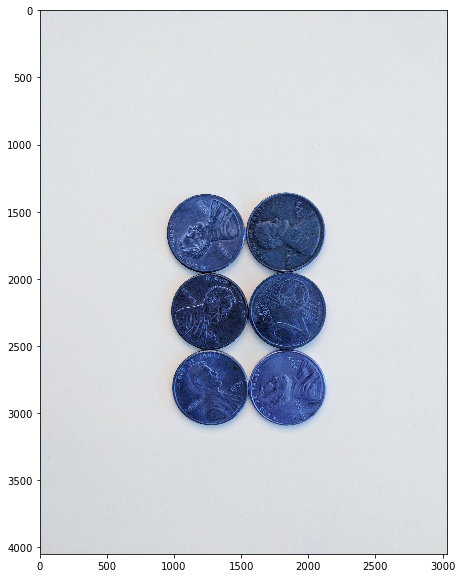

In [7]:
sep_coins = cv2.imread('DATA/pennies.jpg')
display(sep_coins)

In [8]:
#Median Blur
#Gray Scale
#Binary Threshold
#Find Contours

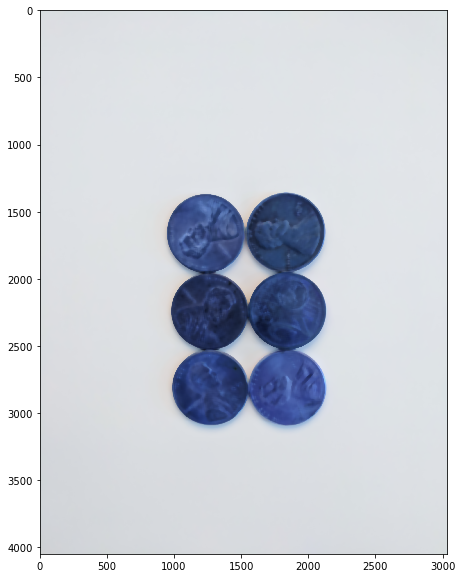

In [10]:
sep_blur = cv2.medianBlur(sep_coins, 25)
display(sep_blur)

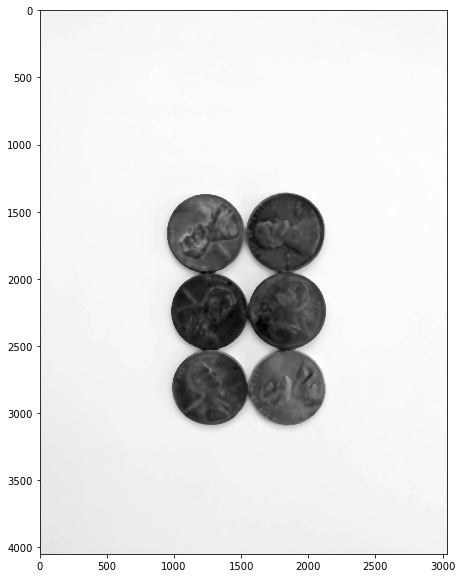

In [11]:
gray_sep_coins = cv2.cvtColor(sep_blur, cv2.COLOR_BGR2GRAY)
display(gray_sep_coins)

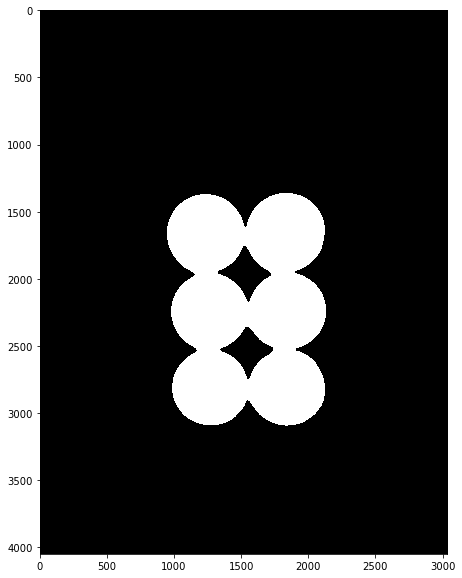

In [12]:
ret, sep_thresh = cv2.threshold(gray_sep_coins, 160, 255, cv2.THRESH_BINARY_INV)
display(sep_thresh)

In [13]:
image, contours, hierarchy = cv2.findContours(sep_thresh.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

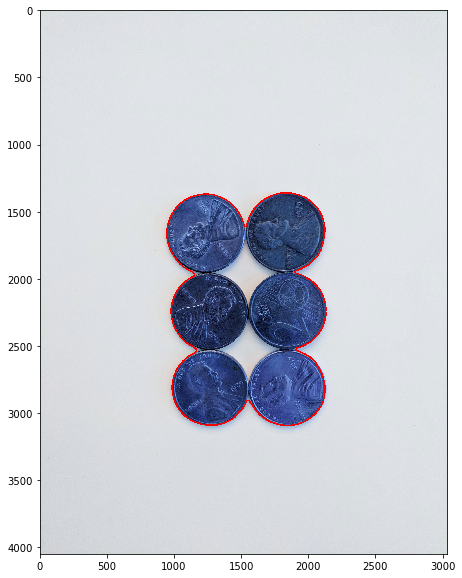

In [14]:
for i in range(len(contours)):
    if hierarchy[0][i][3] == -1:
        cv2.drawContours(sep_coins, contours, i, (255, 0, 0), 10)
display(sep_coins)

## Watershed Algorithm

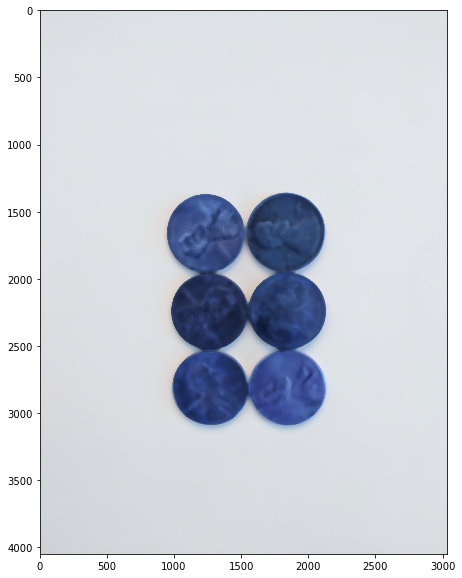

In [15]:
img = cv2.imread('DATA/pennies.jpg')
img = cv2.medianBlur(img, 35) #35 is a good value for this image cause its a huge image
display(img)

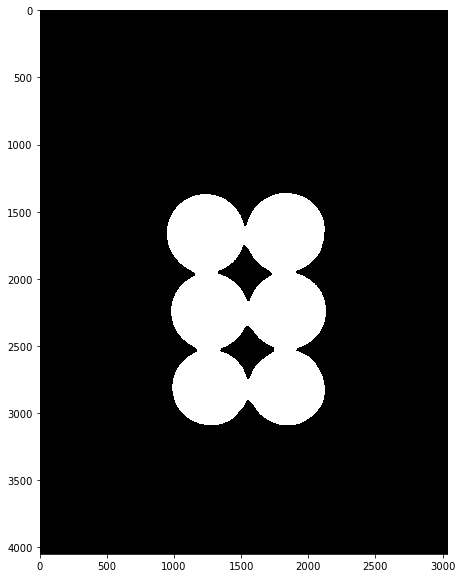

In [16]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
display(thresh)

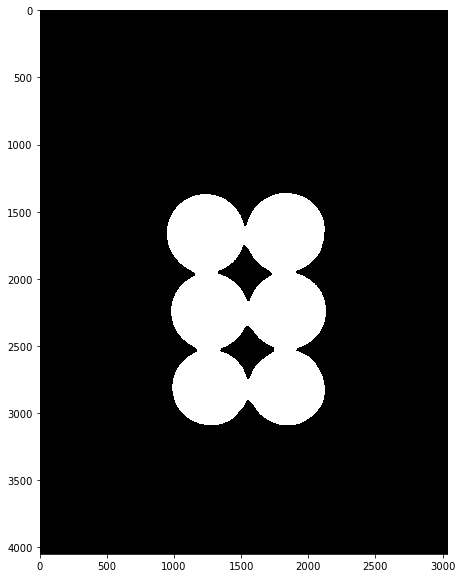

In [17]:
#nosie removal (optional)
kernel = np.ones((3,3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
display(opening)

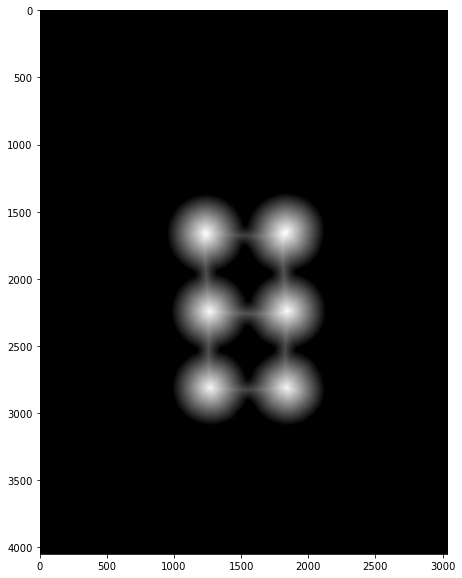

In [18]:
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5) #opening is the input image
display(dist_transform)

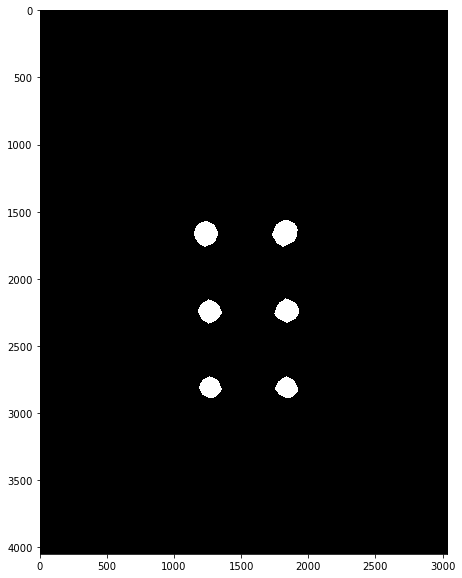

In [19]:
ret, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0) #0.7 of max value
display(sure_fg)

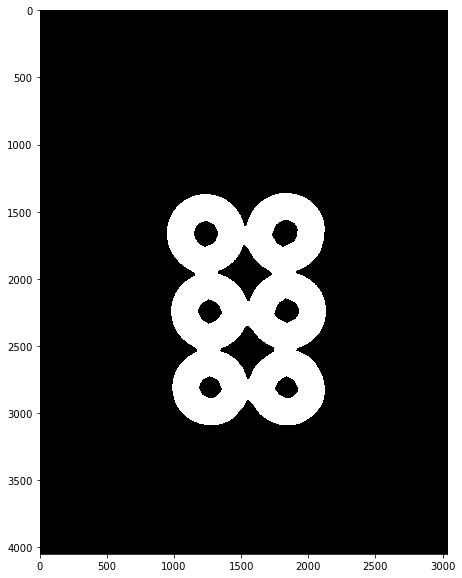

In [20]:
sure_fg = np.uint8(sure_fg) #convert to uint8
unknown = cv2.subtract(opening, sure_fg)
display(unknown)

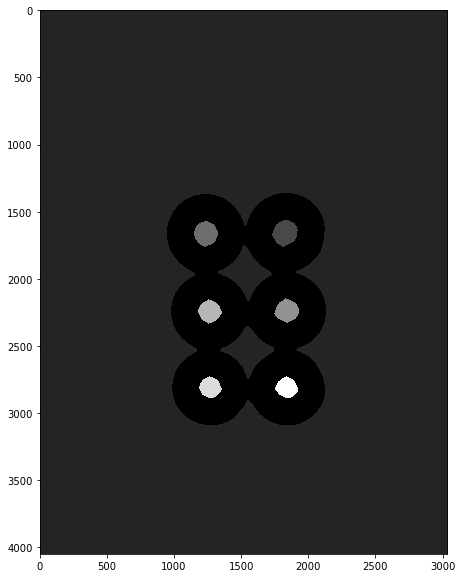

In [21]:
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers+1
markers[unknown==255] = 0 #unknown is 255 so we set it to 0
display(markers)

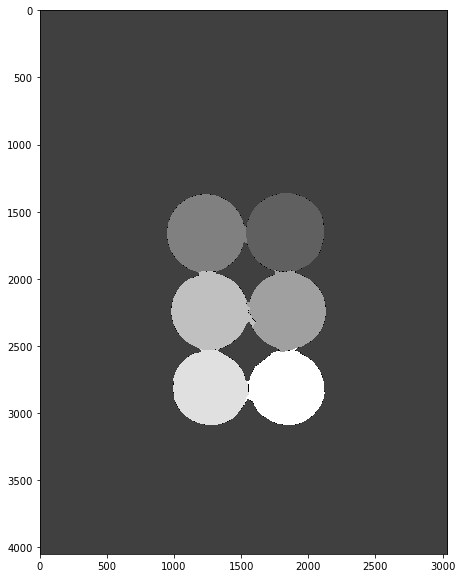

In [22]:
markers = cv2.watershed(img, markers)
display(markers)

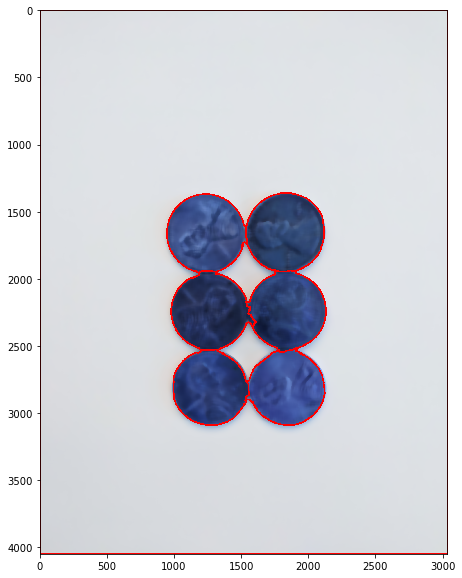

In [23]:
images, contours, hierarchy = cv2.findContours(markers.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
for i in range(len(contours)):
    if hierarchy[0][i][3] == -1:
        cv2.drawContours(img, contours, i, (255, 0, 0), 10)
display(img)

## Watershed Custom Seeds

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
road = cv2.imread('DATA/road_image.jpg')
road_copy = np.copy(road)

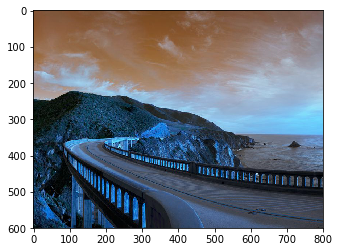

In [3]:
#plt.imshow(road) no color correction because we using opencv not matplotlib

In [4]:
marker_image = np.zeros(road.shape[:2], dtype=np.int32)
segments = np.zeros(road.shape, dtype=np.uint8)

In [5]:
marker_image.shape, segments.shape

((600, 800), (600, 800, 3))

In [6]:
from matplotlib import cm
cm.tab10(0)

(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0)

In [7]:
#index off the color
def create_rgb(i):
    return tuple(np.array(cm.tab10(i))[:3]*255)


In [8]:
colors = [create_rgb(i) for i in range(10)]

In [9]:
colors

[(31.0, 119.0, 180.0),
 (255.0, 127.0, 14.0),
 (44.0, 160.0, 44.0),
 (214.0, 39.0, 40.0),
 (148.0, 103.0, 189.0),
 (140.0, 86.0, 75.0),
 (227.0, 119.0, 194.0),
 (127.0, 127.0, 127.0),
 (188.0, 189.0, 34.0),
 (23.0, 190.0, 207.0)]

In [14]:
###
#Global Variables
#color choice
current_marker = 1
#Markers updated by watershed
marks_updated = False



In [15]:
#Callback Function
def mouse_callback(event, x, y, flags, param):
    global current_marker, marks_updated
    if event == cv2.EVENT_LBUTTONDOWN:
        #Markers passed to the watershed algo
        cv2.circle(marker_image, (x, y), 5, current_marker, -1)
        #user sees on the road image
        cv2.circle(road_copy, (x, y), 5, colors[current_marker], -1)
        marks_updated = True

In [16]:
#while True
cv2.namedWindow('Road Image')
cv2.setMouseCallback('Road Image', mouse_callback)
while True:
    cv2.imshow('Watershed Segments', segments)
    cv2.imshow('Road Image', road_copy)

    #close all windows
    k = cv2.waitKey(1)
    if k == 27:
        break
    #clearing all colors press c key
    elif k == ord('c'):
        marker_image = np.zeros(road.shape[:2], dtype=np.int32)
        road_copy = np.copy(road)
        segments = np.zeros(road.shape, dtype=np.uint8)
    #update the color choice
    elif k > 0 and chr(k).isdigit():
        current_marker = int(chr(k)) #ascii to int conversion
    #update the markings
    if marks_updated:
        markers = marker_image.copy()
        cv2.watershed(road, markers)
        segments = np.zeros(road.shape, dtype=np.uint8)
        for color_index in range(1, 10): #n_markers can work too
            #coloring segments, color choice
            segments[markers == color_index] = colors[color_index]
        marks_updated = False

cv2.destroyAllWindows()